# Sky metrics


In this notebook, I will provide an overview of the sky metrics selected to quantify the night sky spectrum and the results of its subtraction. Metrics are collected per fiber for all telescopes, and these metrics aim to address several key questions:

- Are there variations in sky brightness across the IFU field due to imperfections in flat-fielding or fiber throughput calibration? What is the magnitude of these variations?

- How does the night sky spectrum vary with parameters such as moon distance, moon phase, altitude, seeing, wind, etc.?

- Is there an obvious trend in sky subtraction quality with these parameters?


## Night sky spectra examples

First, preselect several exposures with significantly different shapes of the night sky to demonstrate how the sky metrics look.

To preselect such exposures, I use the `SFrame_summary_skycategories.fits` table, which is generated from `SFrame_summary.fits` provided by Amy at  `https://data.sdss5.org/sas/sdsswork/lvm/spectro/redux/amjones/SFrame_summary.fits`. For details, see the notebook: `https://github.com/sdss/lvmsky/blob/main/notebooks/skySprint_dec2024_investigate_SkySubtraction_metrics.ipynb`.

In [2]:
import os
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

Five metrics are defined to trace sky emission lines (`OI_5577`, `Na_5893`, `OI_6300`, `OH_7341`, `O2_8650`), including the O2 band, as well as three bands to trace the continuum in different parts of the spectrum (`Bcont`, `Rcont`, `Zcont`).

In [5]:
wlines = [
    dict(name='OI_5577', wave=5577.34, line_region=[-3, 3], cont_regions=[[-7, -3], [3, 7]]),
    dict(name='Na_5893', wave=5893, line_region=[-7, 6], cont_regions=[[-11, -7], [6, 10]]),
    dict(name='OI_6300', wave=6300.3, line_region=[-3, 3], cont_regions=[[-8, -5], [10, 14]]),
    dict(name='OH_7341', wave=7340.75, line_region=[-3, 3], cont_regions=[[-7, -3], [3, 7]]),
    dict(name='O2_8650', wave=8650, line_region=[-42, 62], cont_regions=[[-48, -42], [62, 72]]),
]

wconts = [
    dict(name='Bcont', wave=4620, cont_regions=[[-20, 20]]),
    dict(name='Rcont', wave=6765, cont_regions=[[-15, 15]]),
    dict(name='Zcont', wave=9193, cont_regions=[[-15, 15]]),
]

In [4]:
%matplotlib inline
# %matplotlib widget

def plot_sci_sky_spec(file, funcaverage=np.nanmedian):

    wave = fits.getdata(file, 'WAVE')
    slitmap = Table.read(file, hdu='SLITMAP')
    flux = fits.getdata(file, 'FLUX')
    sky = fits.getdata(file, 'SKY')
    spec = flux + sky

    good_fiber_status = slitmap['fibstatus'] == 0
    msk_sci = good_fiber_status & ( slitmap['telescope'] == b'Sci' )
    msk_skyE = good_fiber_status & ( slitmap['telescope'] == b'SkyE' )
    msk_skyW = good_fiber_status & ( slitmap['telescope'] == b'SkyW' )

    s_sci = funcaverage(spec[msk_sci,: ], axis=0)
    s_skyE = funcaverage(spec[msk_skyE,: ], axis=0)
    s_skyW = funcaverage(spec[msk_skyW,: ], axis=0)

    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 6, wspace=0.3, hspace=0.3, width_ratios=[1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1])
    ax_full = fig.add_subplot(gs[0, :])
    ax11 = fig.add_subplot(gs[1, 0])
    ax12 = fig.add_subplot(gs[1, 1])
    ax13 = fig.add_subplot(gs[1, 2])
    ax14 = fig.add_subplot(gs[1, 3])
    ax15 = fig.add_subplot(gs[1, 4:])
    ax21 = fig.add_subplot(gs[2, 0:2])
    ax22 = fig.add_subplot(gs[2, 2:4])
    ax23 = fig.add_subplot(gs[2, 4:6])

    ax_full.axhline(1e-12, color='C4', linestyle='--', label='Ref. 1e-12')
    ax_full.axhline(1e-13, color='C5', linestyle='--', label='Ref. 1e-13')
    ax_full.axhline(1e-14, color='C6', linestyle='--', label='Ref. 1e-14')

    ax_full.plot(wave, s_skyE, color='C0', label='SkyE')
    ax_full.plot(wave, s_skyW, color='C2', label='SkyW')
    ax_full.plot(wave, s_sci, color='k', lw=1.0, label='Sci')

    axs = ax11, ax12, ax13, ax14, ax15
    for i, wl in enumerate(wlines):

        msk = ( wave >= (wl['wave'] + np.min(wl["cont_regions"]) - 2) ) & \
              ( wave <= (wl['wave'] + np.max(wl["cont_regions"]) + 2) )
        msk_cont = ( ( wave >= wl['wave'] + wl['cont_regions'][0][0] ) & ( wave < wl['wave'] + wl['cont_regions'][0][1] ) ) | \
                   ( ( wave > wl['wave'] + wl['cont_regions'][1][0] ) & ( wave <= wl['wave'] + wl['cont_regions'][1][1] ) )

        cont_level = np.nanmedian(s_sci[msk_cont])

        axs[i].plot(wave[msk], s_skyE[msk], color='C0')
        axs[i].plot(wave[msk], s_skyW[msk], color='C2')
        axs[i].plot(wave[msk], s_sci[msk], color='k', lw=1.0)
        axs[i].axvline(wl['wave'], linestyle=':', color='k', lw=0.5)
        axs[i].axhline(cont_level, linestyle='--', color='k', lw=0.5)
        for ax in axs[i], ax_full:
            ax.axvspan(wl['wave']+wl['line_region'][0], wl['wave']+wl['line_region'][1], color='lightgrey', alpha=0.3)
        axs[i].set_title(wl['name'])
        for cont_region in wl['cont_regions']:
            axs[i].axvspan(wl['wave']+cont_region[0], wl['wave']+cont_region[1], color='lightgrey', edgecolor=None, alpha=0.2, hatch='//')

    axsc = ax21, ax22, ax23
    for i, wl in enumerate(wconts):

        msk = ( wave >= (wl['wave'] + np.min(wl["cont_regions"]) - 50) ) & \
              ( wave <= (wl['wave'] + np.max(wl["cont_regions"]) + 50) )
        msk_cont = ( ( wave >= wl['wave'] + wl['cont_regions'][0][0] ) & ( wave < wl['wave'] + wl['cont_regions'][0][1] ) )

        cont_level = np.nanmedian(s_sci[msk_cont])

        axsc[i].plot(wave[msk], s_skyE[msk], color='C0')
        axsc[i].plot(wave[msk], s_skyW[msk], color='C2')
        axsc[i].plot(wave[msk], s_sci[msk], color='k', lw=1.0)
        axsc[i].axvline(wl['wave'], linestyle=':', color='k', lw=0.5)
        axsc[i].axhline(cont_level, linestyle='--', color='k', lw=0.5)
        for ax in axsc[i], ax_full:
            ax.axvspan(wl['wave']+wl['cont_regions'][0][0], wl['wave']+wl['cont_regions'][0][1], color='lightgrey', alpha=0.3)
        axsc[i].set_title(wl['name'])

    ax_full.set_title(file.split('sdsswork/lvm/spectro/redux/')[1])
    # plt.yscale('log')
    ax_full.legend(ncols=6)
    plt.show()

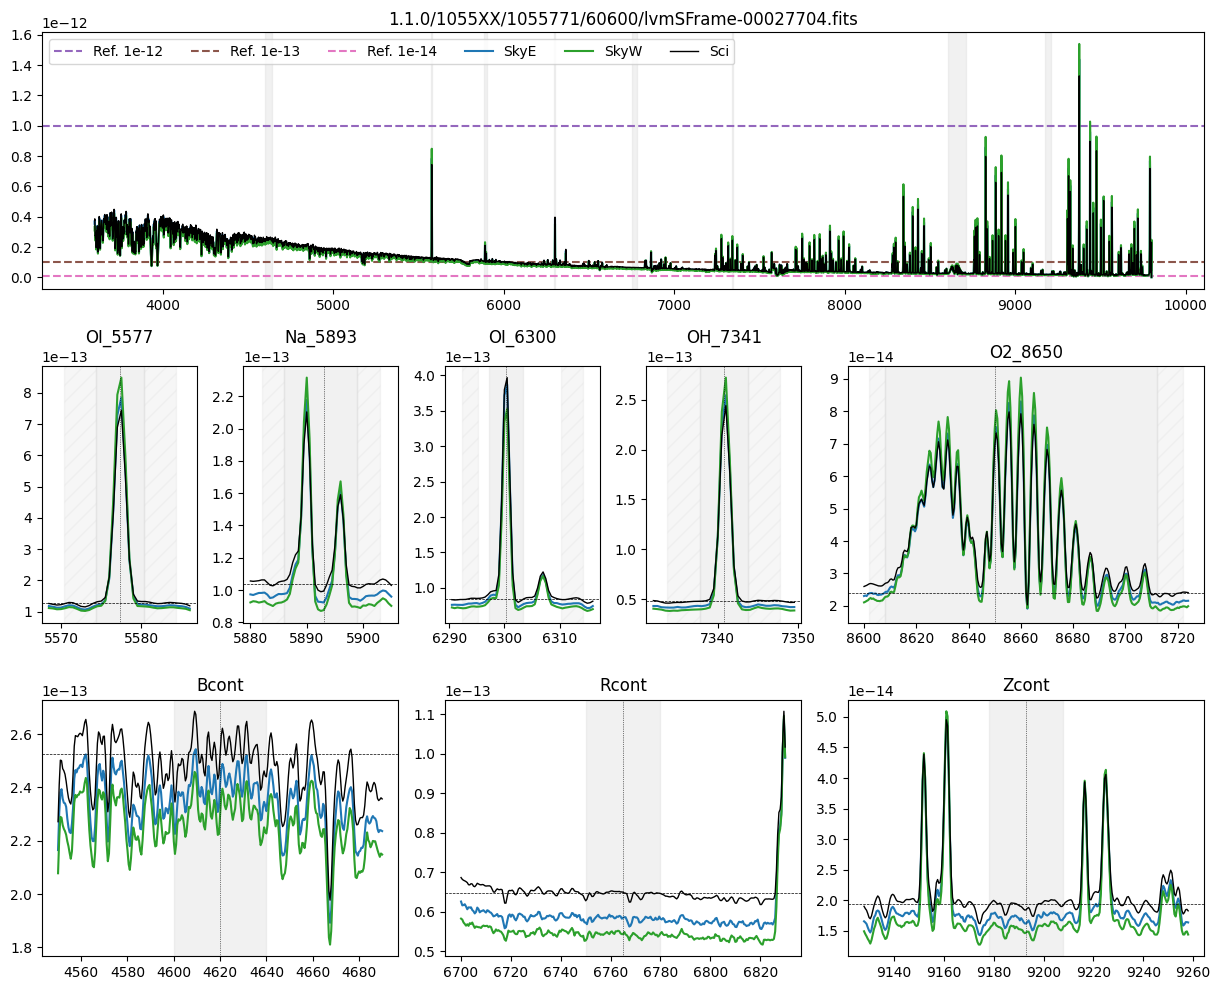

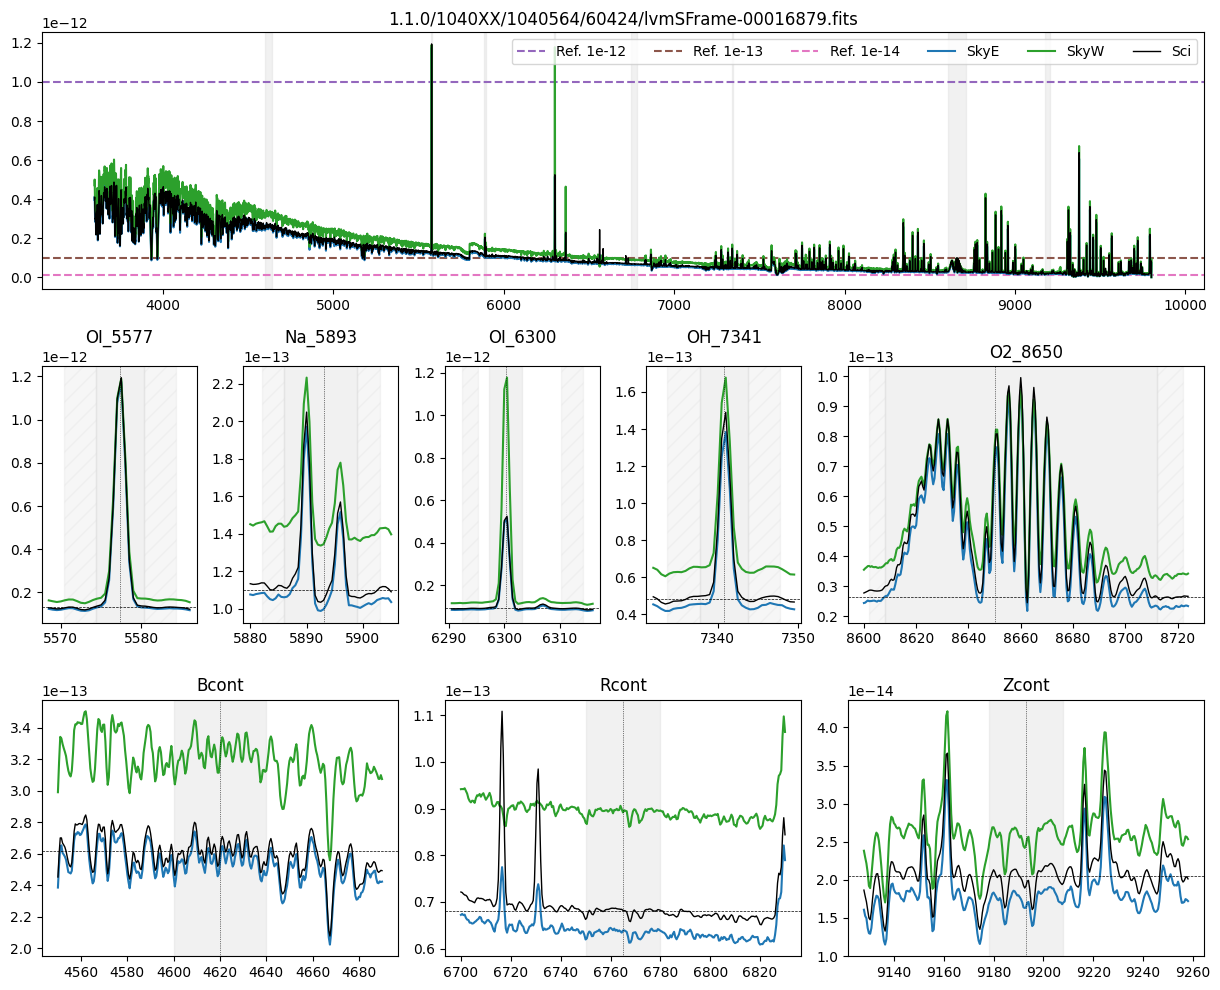

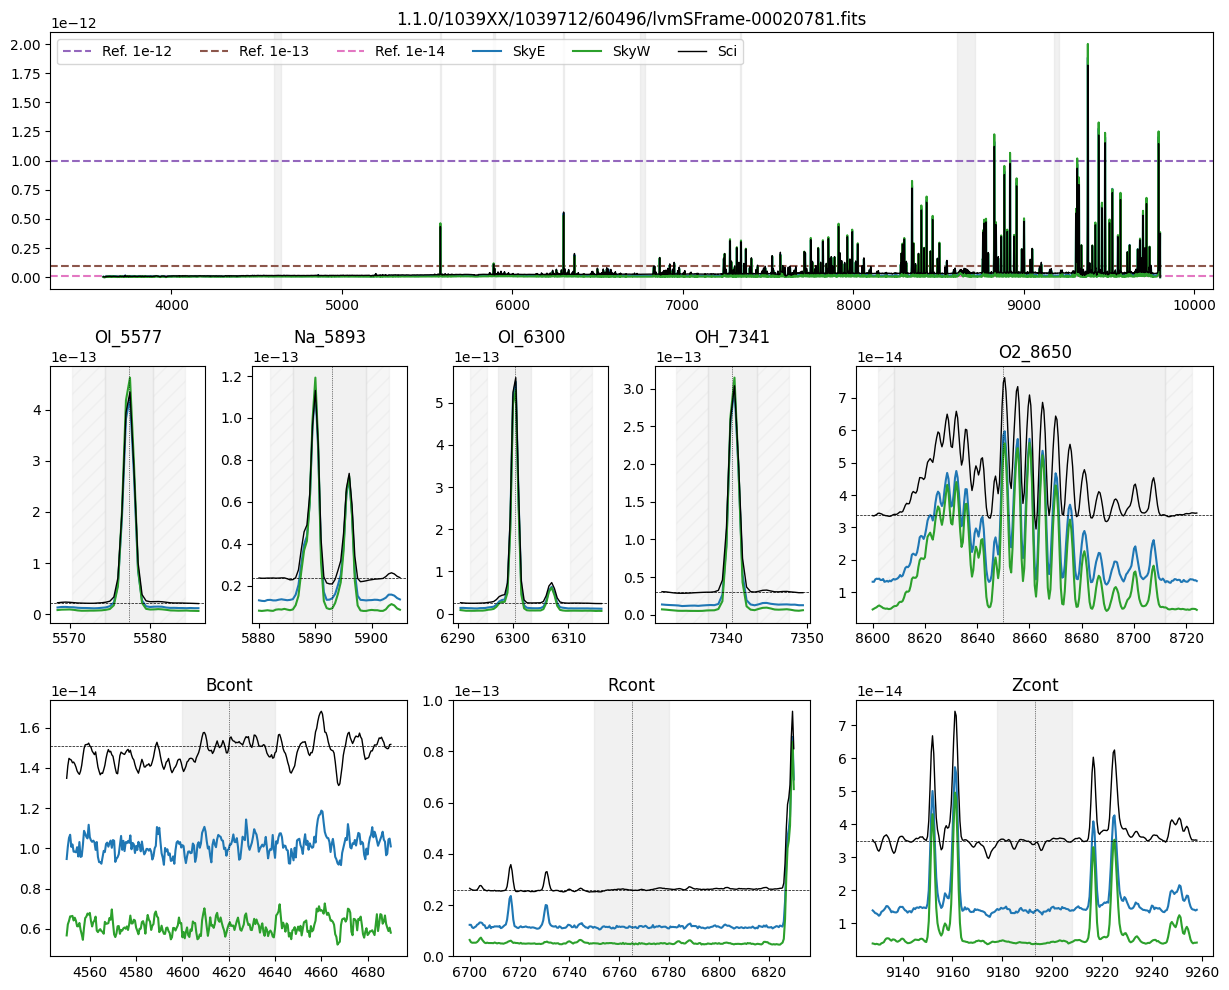

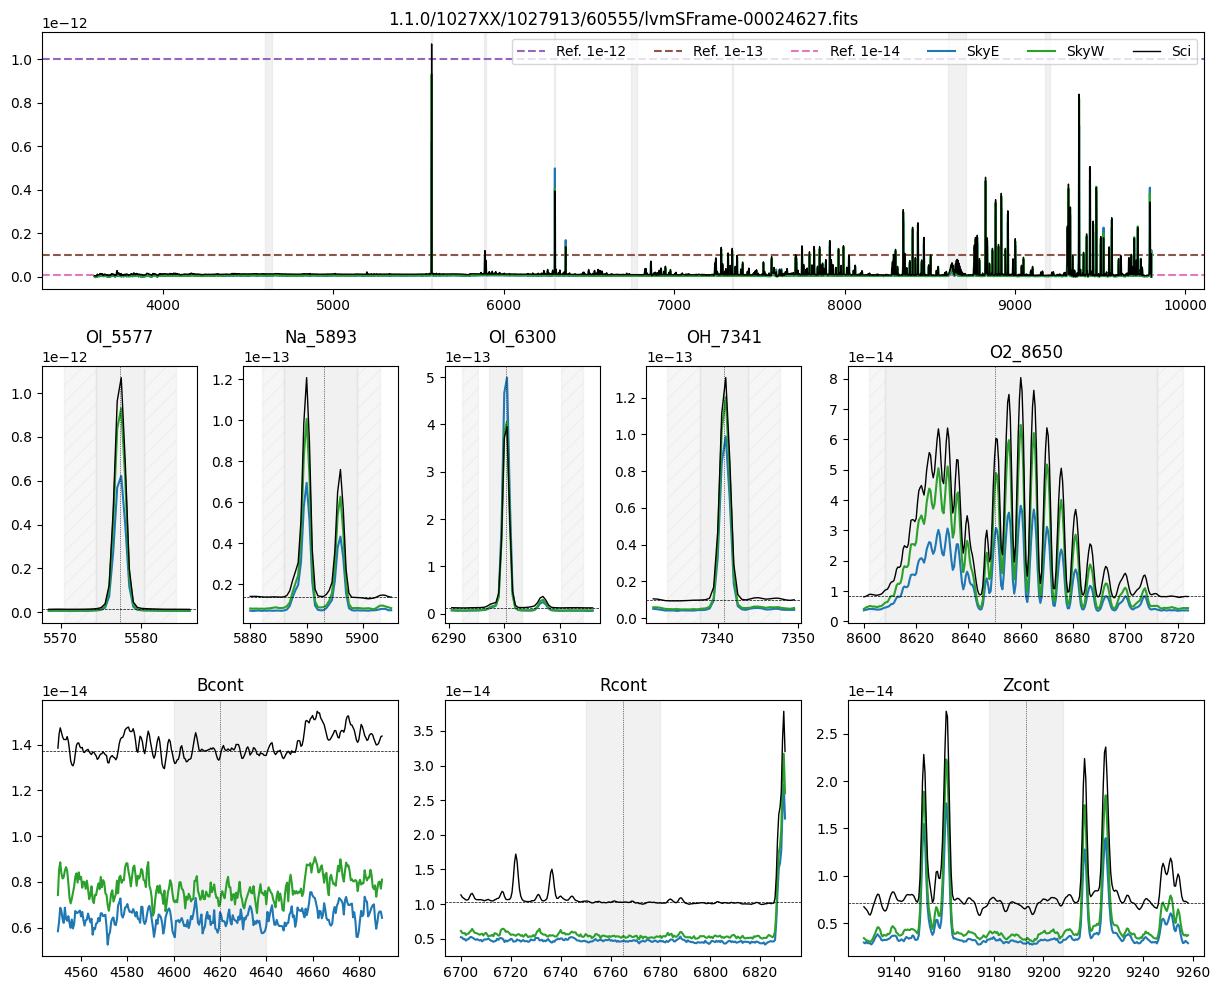

In [6]:
%matplotlib inline
# %matplotlib widget

sas = os.getenv('SAS_BASE_DIR')

files = [
    'sdsswork/lvm/spectro/redux/1.1.0/1055XX/1055771/60600/lvmSFrame-00027704.fits', # Full moon, close to the moon
    'sdsswork/lvm/spectro/redux/1.1.0/1040XX/1040564/60424/lvmSFrame-00016879.fits', # Full moon, far from the moon
    'sdsswork/lvm/spectro/redux/1.1.0/1039XX/1039712/60496/lvmSFrame-00020781.fits', # Darkest, no moon, sci airmas~1
    'sdsswork/lvm/spectro/redux/1.1.0/1027XX/1027913/60555/lvmSFrame-00024627.fits', # Dart, sci airmass~2
]

plt.close('all')
for file in files:
    plot_sci_sky_spec(os.path.join(sas, file))

Now encorporate definitions of the metrics `wlines` and `wconts` into the script `collect_fiber_metrics.py` to process SFrame files.



Below few more example of spectra.

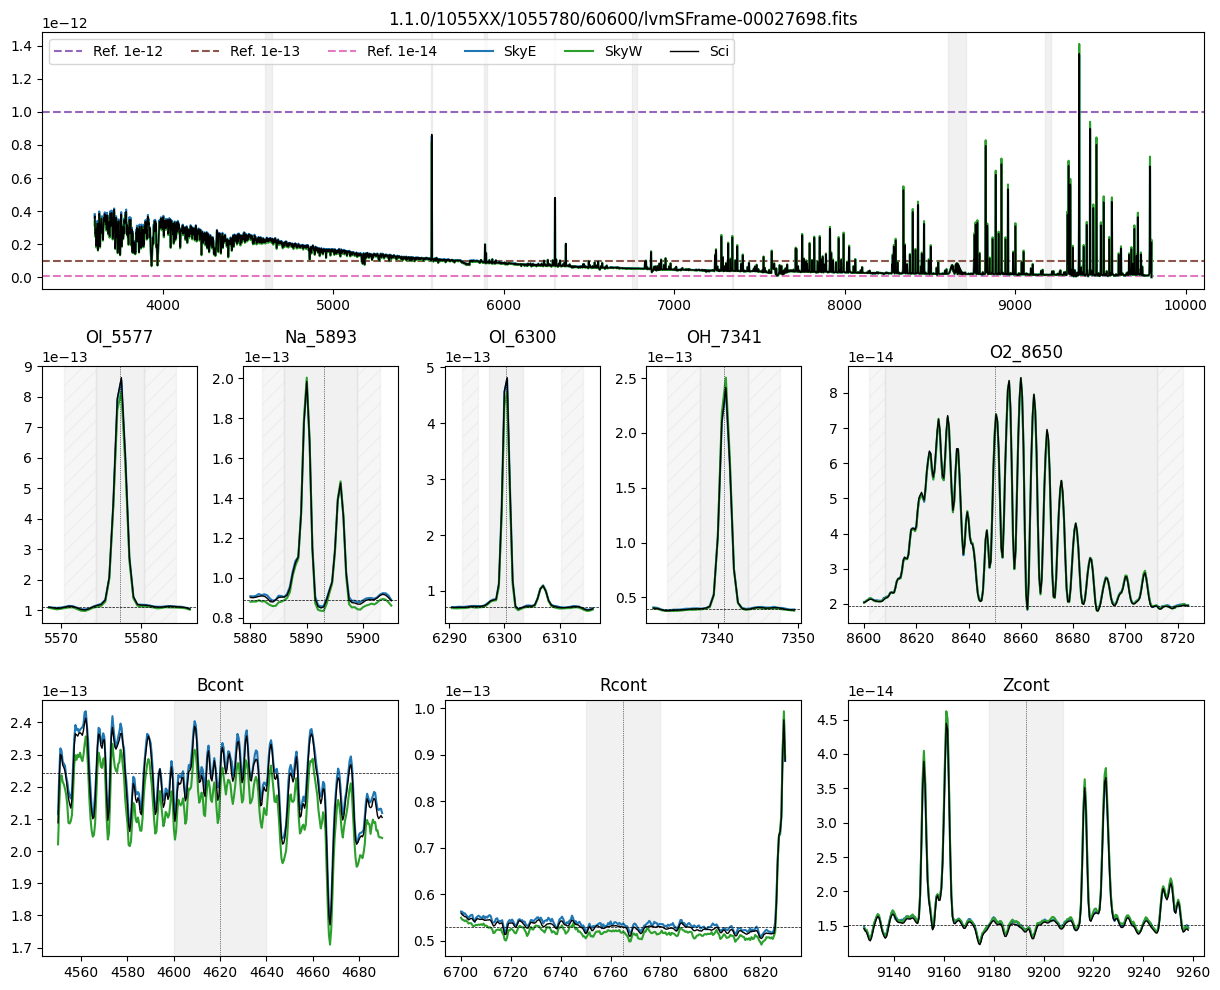

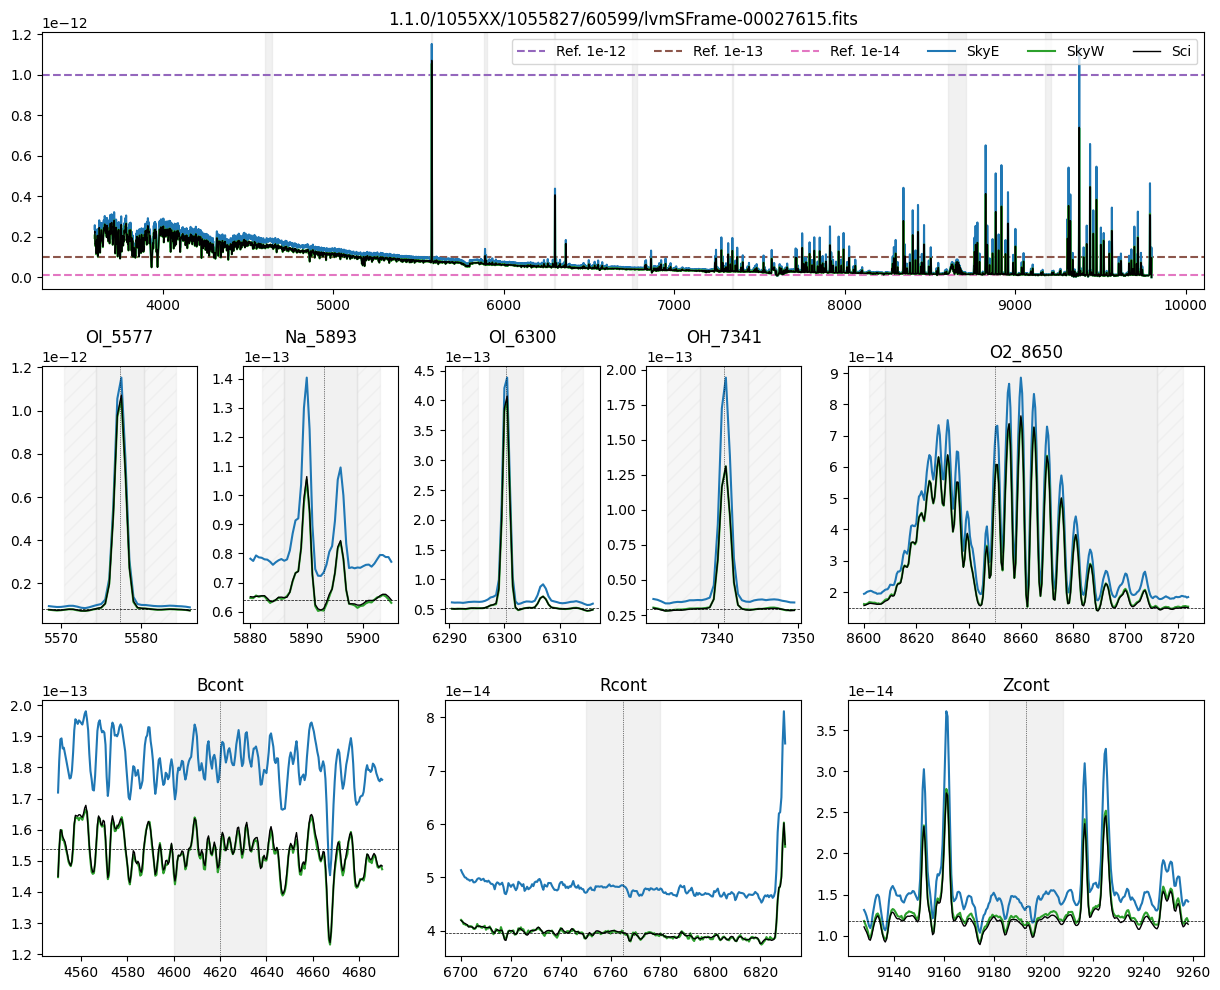

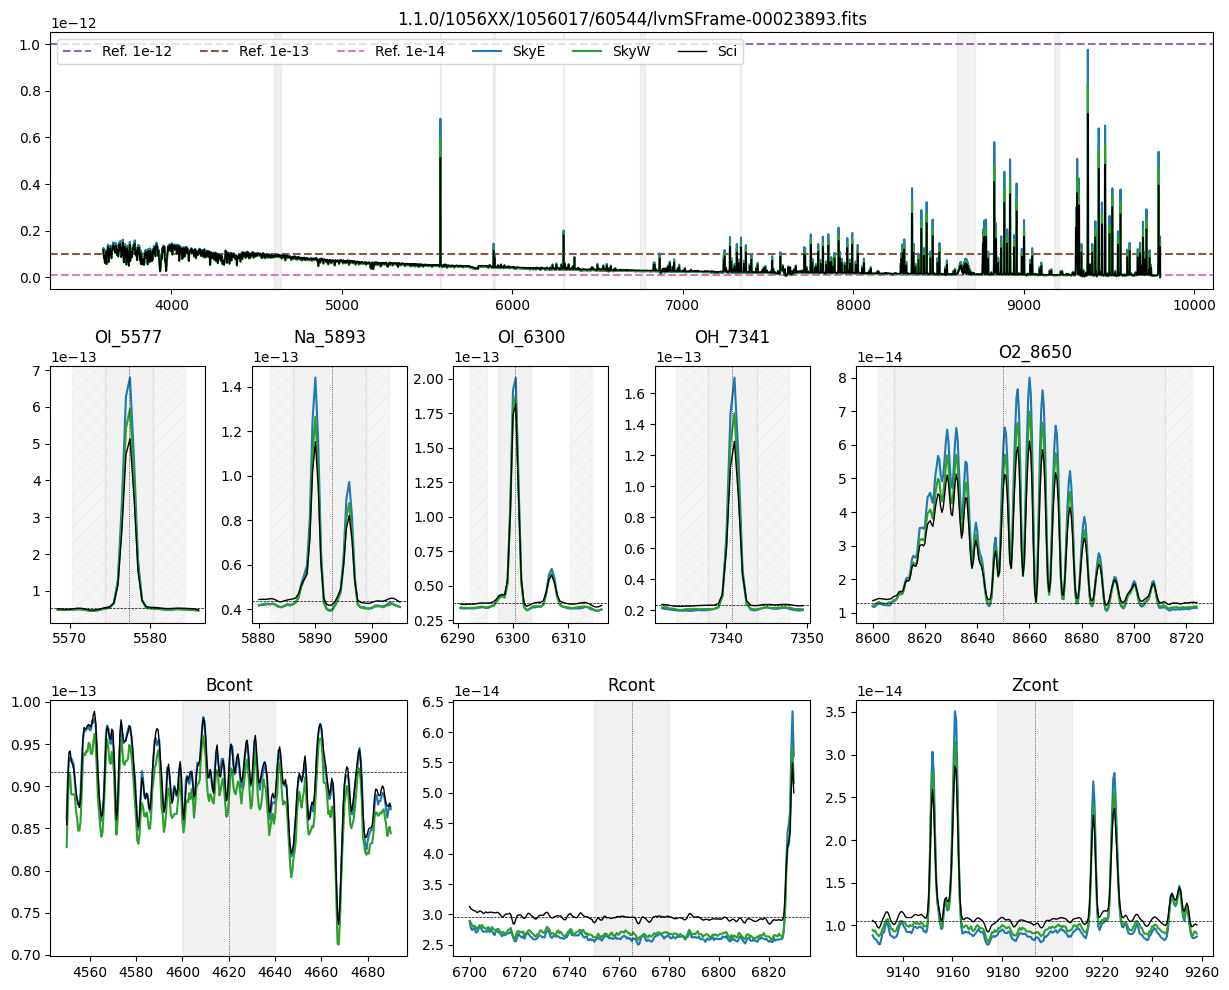

In [7]:
%matplotlib inline
# %matplotlib widget

sas = os.getenv('SAS_BASE_DIR')

files = [
    'sdsswork/lvm/spectro/redux/1.1.0/1055XX/1055780/60600/lvmSFrame-00027698.fits',
    'sdsswork/lvm/spectro/redux/1.1.0/1055XX/1055827/60599/lvmSFrame-00027615.fits',
    'sdsswork/lvm/spectro/redux/1.1.0/1056XX/1056017/60544/lvmSFrame-00023893.fits',
]

plt.close('all')
for file in files:
    plot_sci_sky_spec(os.path.join(sas, file))

# Metrics to highlight 5800A jump


In this section we introduce a few more metrics to be able selecting spectra with jump around 5800 A issue.

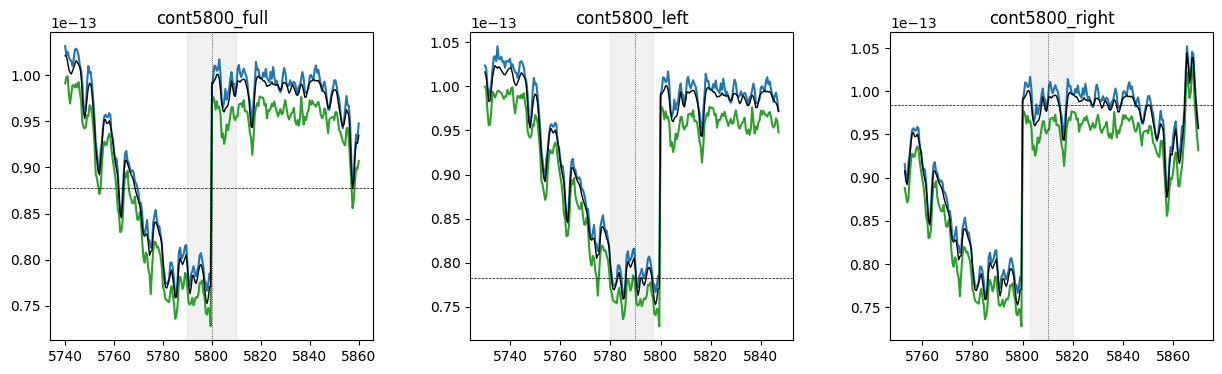

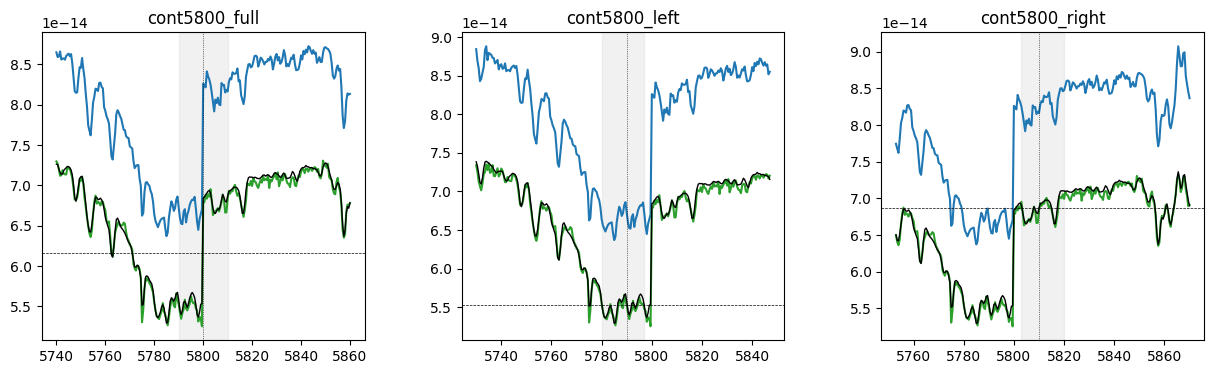

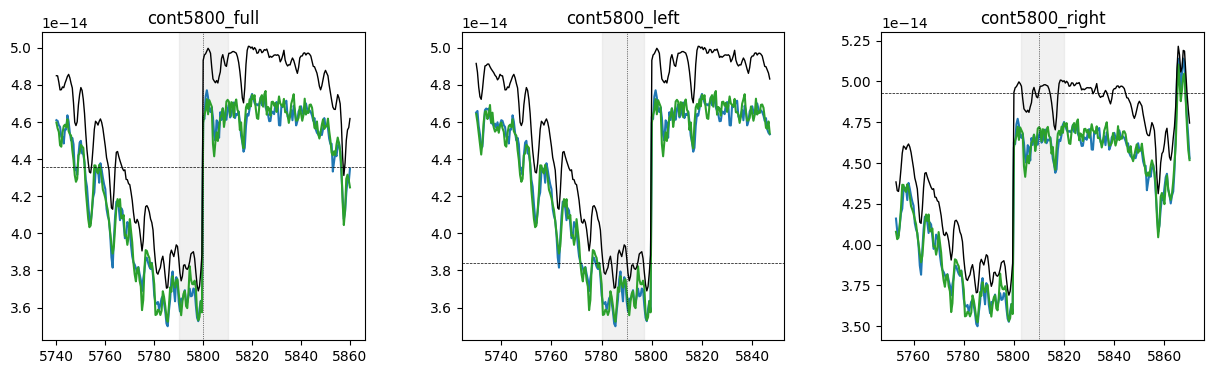

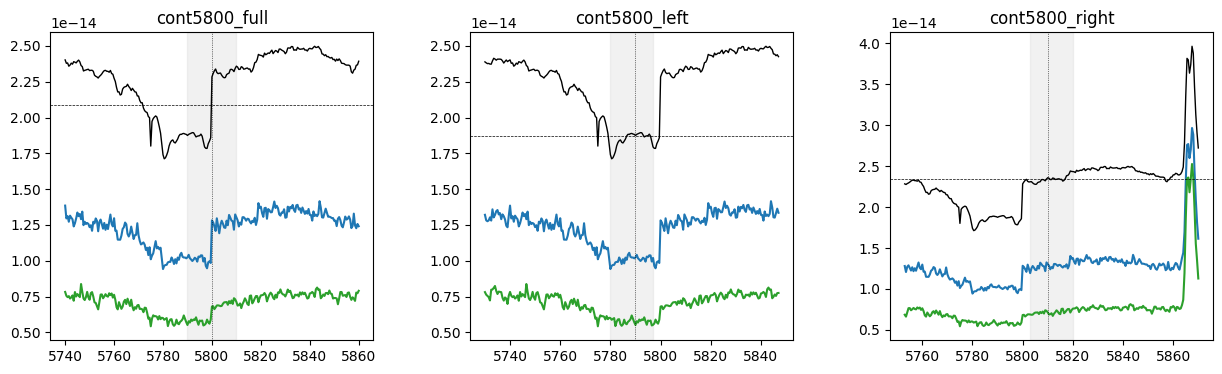

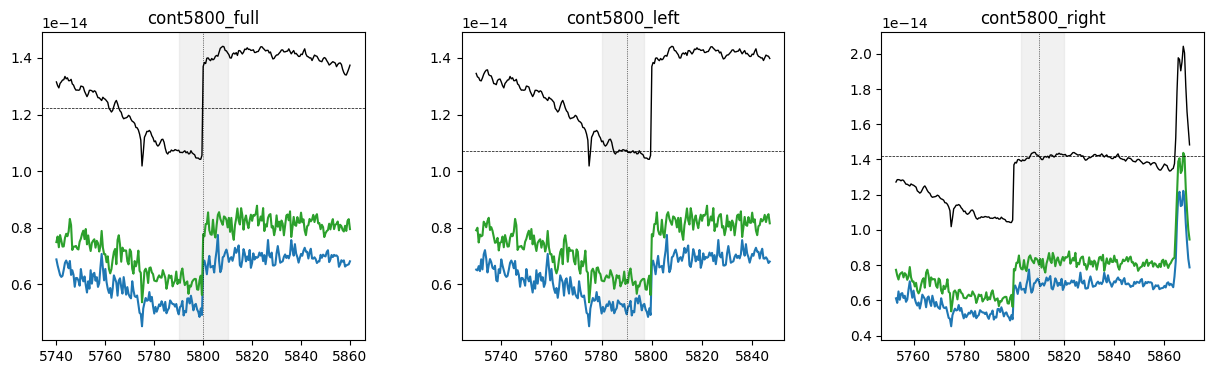

In [8]:
%matplotlib inline
# %matplotlib widget


wcont5800 = [
    dict(name='cont5800_full', wave=5800, cont_regions=[[-10, 10]]),
    dict(name='cont5800_left', wave=5800-10, cont_regions=[[-10, 7]]),
    dict(name='cont5800_right', wave=5800+10, cont_regions=[[-7, 10]]),
]


def plot_sci_sky_jump5800(file, funcaverage=np.nanmedian):

    wave = fits.getdata(file, 'WAVE')
    slitmap = Table.read(file, hdu='SLITMAP')
    flux = fits.getdata(file, 'FLUX')
    sky = fits.getdata(file, 'SKY')
    spec = flux + sky

    good_fiber_status = slitmap['fibstatus'] == 0
    msk_sci = good_fiber_status & ( slitmap['telescope'] == b'Sci' )
    msk_skyE = good_fiber_status & ( slitmap['telescope'] == b'SkyE' )
    msk_skyW = good_fiber_status & ( slitmap['telescope'] == b'SkyW' )

    s_sci = funcaverage(spec[msk_sci,: ], axis=0)
    s_skyE = funcaverage(spec[msk_skyE,: ], axis=0)
    s_skyW = funcaverage(spec[msk_skyW,: ], axis=0)

    fig = plt.figure(figsize=(15, 4))
    gs = GridSpec(1, 3, wspace=0.3, hspace=0.3, width_ratios=[1, 1, 1], height_ratios=[1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    axsc = ax1, ax2, ax3
    for i, wl in enumerate(wcont5800):

        msk = ( wave >= (wl['wave'] + np.min(wl["cont_regions"]) - 50) ) & \
              ( wave <= (wl['wave'] + np.max(wl["cont_regions"]) + 50) )
        msk_cont = ( ( wave >= wl['wave'] + wl['cont_regions'][0][0] ) & ( wave < wl['wave'] + wl['cont_regions'][0][1] ) )

        cont_level = np.nanmedian(s_sci[msk_cont])

        axsc[i].plot(wave[msk], s_skyE[msk], color='C0')
        axsc[i].plot(wave[msk], s_skyW[msk], color='C2')
        axsc[i].plot(wave[msk], s_sci[msk], color='k', lw=1.0)
        axsc[i].axvline(wl['wave'], linestyle=':', color='k', lw=0.5)
        axsc[i].axhline(cont_level, linestyle='--', color='k', lw=0.5)
        axsc[i].axvspan(wl['wave']+wl['cont_regions'][0][0], wl['wave']+wl['cont_regions'][0][1], color='lightgrey', alpha=0.3)
        axsc[i].set_title(wl['name'])

    # ax_full.set_title(file.split('sdsswork/lvm/spectro/redux/')[1])
    # # plt.yscale('log')
    # ax_full.legend(ncols=6)
    plt.show()


sas = os.getenv('SAS_BASE_DIR')

files = [
    'sdsswork/lvm/spectro/redux/1.1.0/1055XX/1055780/60600/lvmSFrame-00027698.fits',
    'sdsswork/lvm/spectro/redux/1.1.0/1055XX/1055827/60599/lvmSFrame-00027615.fits',
    'sdsswork/lvm/spectro/redux/1.1.0/1056XX/1056017/60544/lvmSFrame-00023893.fits',
    # and two scpetra with low continuum level
    'sdsswork/lvm/spectro/redux/1.1.0/1039XX/1039712/60496/lvmSFrame-00020781.fits', # Darkest, no moon, sci airmas~1
    'sdsswork/lvm/spectro/redux/1.1.0/1027XX/1027913/60555/lvmSFrame-00024627.fits', # Dart, sci airmass~2
]

plt.close('all')
for file in files:
    plot_sci_sky_jump5800(os.path.join(sas, file))

### Summary

Even spectra with low continuum level can clearly exsibit jusmp around 5800 A.